In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

# Voroni diagram

Use the library code to generate a Voroni diagram from the input data, and then redistribute points in the cells.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import open_cp.geometry
open_cp.geometry.configure_gdal()
import opencrimedata.san_francisco as sf
import opencrimedata.geometry
import opencrimedata.voroni
import opencrimedata.replace
import opencrimedata.tiger_lines
import bz2
import geopandas as gpd
import descartes
import pyproj
proj = pyproj.Proj({"init":"EPSG:2768"})
import tilemapbase
tilemapbase.start_logging()
pyproj.__version__

'1.9.5.1'

### Use the library code to load San Francisco crime data

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("e:\\", "Data")
def gen():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from sf.load(f)

next(gen())

Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42158168137, 37.7617007179518), idd='15006027571000', incident='150060275')

In [4]:
points = np.asarray([row.point for row in gen()])
xcs, ycs = proj(*points.T)
points = np.asarray([xcs, ycs]).T

### Construct a Voroni diagram

We use the library code to construct a voroni diagram.
- This is a wrapper around the `scipy` code, with added functionality to make extracting voroni cells almost trivial.
- We also "merge" the input points.
- This uses the `opencrimedata.geometry.AggregatePointsViaGraph` class

In [5]:
voroni = opencrimedata.voroni.Voroni(points, tolerance=1)

### Make a plot

In [6]:
def project_to_wm(xcs, ycs):
    xcs, ycs = proj(xcs, ycs, inverse=True)
    points = [tilemapbase.project(x, y) for x, y in zip(xcs, ycs)]
    return np.asarray(points)

pts_wm = project_to_wm(xcs, ycs)

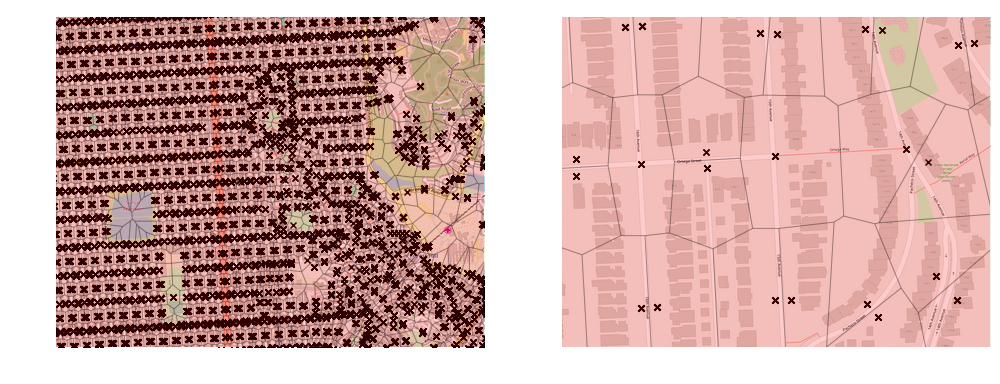

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.0001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[0])

ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[1])

for ax in axes:
    ax.set_axis_off()
    for p in voroni.all_polygons():
        p = project_to_wm(*np.asarray(p).T)
        poly = matplotlib.patches.Polygon(p, ec="black", fc="red", alpha=0.2)
        ax.add_patch(poly)

    ax.scatter(*pts_wm.T, marker="x", color="black")

fig.tight_layout()

In [8]:
fig.savefig("sf_vor_1.png", dpi=100)

## Clip to outline

We load the geometry file giving the outline of San Francisco, and then form a `Redistibutor` class which handles generating random locations within voroni cells; those cells having been clipped to the geometry.

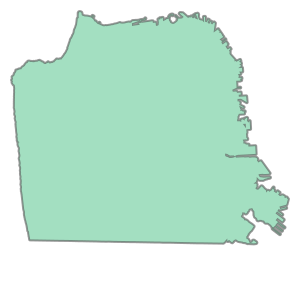

In [9]:
frame = gpd.io.file.read_file(os.path.join(datadir, "SF_Neighborhood_Quadrants.geojson"))
frame = frame.to_crs({"init":"EPSG:2768"})
sanfran_geo = frame.unary_union
outline = sanfran_geo.buffer(45)
outline

In [10]:
redist = voroni.to_redistributor(outline)

## Example redistribution

It's quicker to wrap into a `CachingRedistributor`.  Our library relies on `numpy` for random numbers, so we set the seed to get a reproducible result.

In [11]:
redist = opencrimedata.geometry.CachingRedistributor(redist.polygons)

Using 17


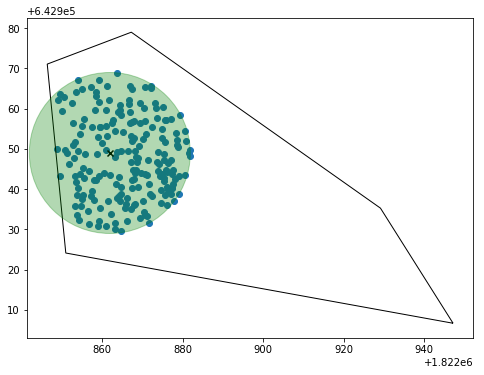

In [12]:
for i in range(len(redist.polygons)):
    poly = redist.polygons[i]
    x, y = voroni.merged_points[i]
    assert redist.find_containing_polygon(x, y) == [i]
    if poly.area < 4000:
        break
print("Using", i)
pts = np.asarray([redist.redistribute_within_radius(x, y, 20) for _ in range(200)])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*pts.T)
ax.add_patch(descartes.PolygonPatch(poly, fc="none"))
ax.scatter(x, y, marker="x", color="black")
ax.add_patch(matplotlib.patches.Circle([x,y], 20, alpha=0.3, color="green"))
ax.set_aspect(1)
None

## Create an entirely new file

Recreate the `redist` to make sure that setting the `numpy` random seed in `MyAssign` works.

In [13]:
redist = opencrimedata.geometry.CachingRedistributor(redist.polygons)

In [14]:
class MyAssign(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        x, y = proj(*row.point)
        pt = redist.redistribute_within_radius(x, y, 200)
        if pt is None:
            return None
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))

assign = MyAssign(gen(), seed=1234)

new_data = list(assign)

In [15]:
filename = os.path.join(datadir, "SF_Redist_1.csv.bz2")
with bz2.open(filename, "wt", newline="", encoding="UTF8") as f:
    sf.write(f, new_data)

Our input file has hash: `a100b6d9c6369b4c52acdcc1fe8e53c79ddc06f0146266b14f75cffb8e635e68`

In [16]:
assign.input_hash

'a100b6d9c6369b4c52acdcc1fe8e53c79ddc06f0146266b14f75cffb8e635e68'

- New data has hash:
  - pc: `ffd8a8c168b8630f948fb5238cea29083f0e1b967e3780f201d7511059b05382`
- Failed to assign count: 3992
- Total input size: 2119901

In [17]:
assign.output_hash

'c2806f1e3598e30d7cf3971d860ac93442a89a2119bc9e48f9c719a9d411d523'

In [18]:
assign.input_size, assign.failed_to_reassign_count

(2119901, 3992)

## Load back in and check

In [19]:
def gen_new():
    with bz2.open(filename, "rt", newline="", encoding="UTF8") as f:
        yield from sf.load(f)

generator = gen_new()
for row in new_data:
    assert next(generator) == row
    
try:
    next(generator)
except StopIteration:
    print("As expected")

As expected


## Plot for paper

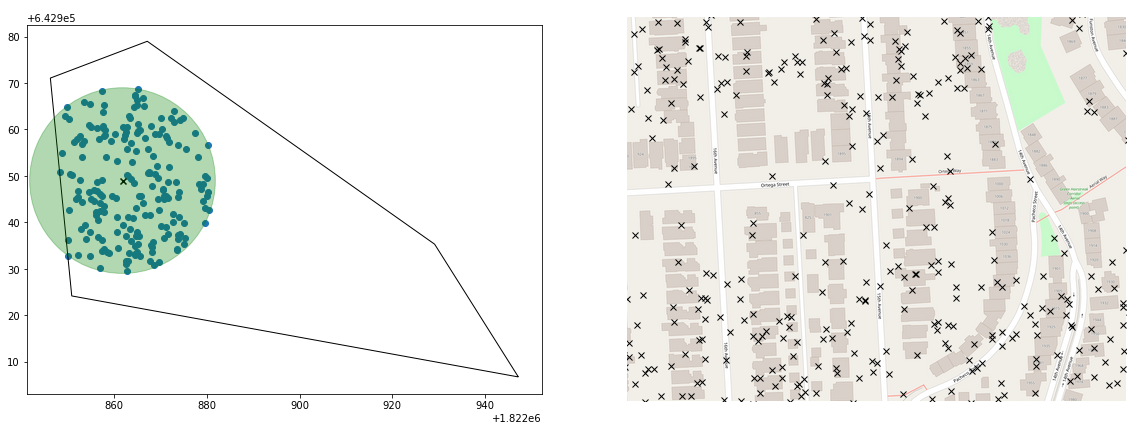

In [21]:
poly = redist.polygons[17]
x, y = voroni.merged_points[17]
pts = np.asarray([redist.redistribute_within_radius(x, y, 20) for _ in range(200)])

fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ax.scatter(*pts.T)
ax.add_patch(descartes.PolygonPatch(poly, fc="none"))
ax.scatter(x, y, marker="x", color="black")
ax.add_patch(matplotlib.patches.Circle([x,y], 20, alpha=0.3, color="green"))
ax.set_aspect(1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)
ax.set_axis_off()

pts = [tilemapbase.project(*row.point) for row in new_data]
ax.scatter(*np.asarray(pts).T, marker="x", color="black", linewidth=1)

fig.tight_layout()

In [22]:
fig.savefig("sf_vor_2.png", dpi=100)

## Look at distribution of cell sizes

For later network work, I am interested in the distribution of voroni cell sizes.

In [22]:
def gen_streets():
    filename = os.path.join(datadir, "San Francisco Basemap Street Centerlines")
    for row in opencrimedata.san_francisco.load_street_centre_lines(filename):
        if opencrimedata.san_francisco.street_layer_accept(row):
            yield row
            
proj = opencrimedata.san_francisco.projector()

def proj_street(street):
    line = np.asarray(street.line)
    return np.asarray(proj(*line.T)).T

graph, graph_names = opencrimedata.geometry.graph_from_streets(gen_streets(), proj_street)

In [33]:
tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
tldata = opencrimedata.tiger_lines.TigerLines(
    os.path.join(tigerdir, "tl_2016_06075_roads__san_francisco"),
    os.path.join(tigerdir, "tl_2016_06075_edges__san_francisco"),
    proj)

In [34]:
tl_graph, _ = tldata.make_reduced_graph()

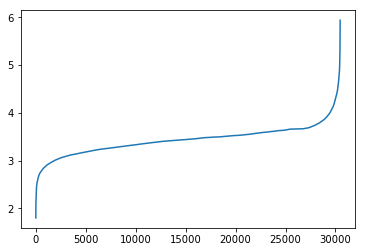

In [23]:
areas = [p.area for p in redist.polygons]
areas_sort_indices = np.argsort(areas)
areas = np.asarray(areas)[areas_sort_indices]
plt.plot(np.log10(areas))

In [35]:
import shapely.ops
def project(x, y):
    return tilemapbase.project(*proj(x, y, inverse=True))

gr_lines = [[project(*pt) for pt in line] for line in graph.as_lines()]
tl_lines = [[project(*pt) for pt in line] for line in tl_graph.as_lines()]

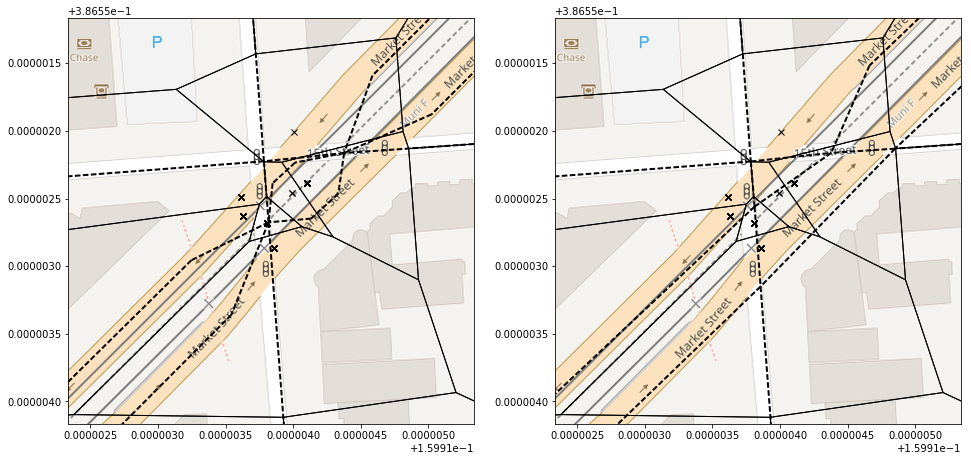

In [36]:
p = redist.polygons[areas_sort_indices[0]]
x, y = list(p.centroid.coords)[0]
ex = tilemapbase.Extent.from_centre(*project(x, y), xsize=0.000003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax in axes:
    plotter.plot(ax, alpha=0.7)

    for p in redist.polygons:
        p = shapely.ops.transform(project, p)
        p = descartes.PolygonPatch(p, fc="none", ec="black", linewidth=1)
        ax.add_patch(p)
    
    ax.scatter(*pts_wm.T, linewidth=1, color="black", marker="x")

l = matplotlib.collections.LineCollection(gr_lines, linewidth=2, color="black", linestyle="--")
axes[0].add_collection(l)

l = matplotlib.collections.LineCollection(tl_lines, linewidth=2, color="black", linestyle="--")
axes[1].add_collection(l)

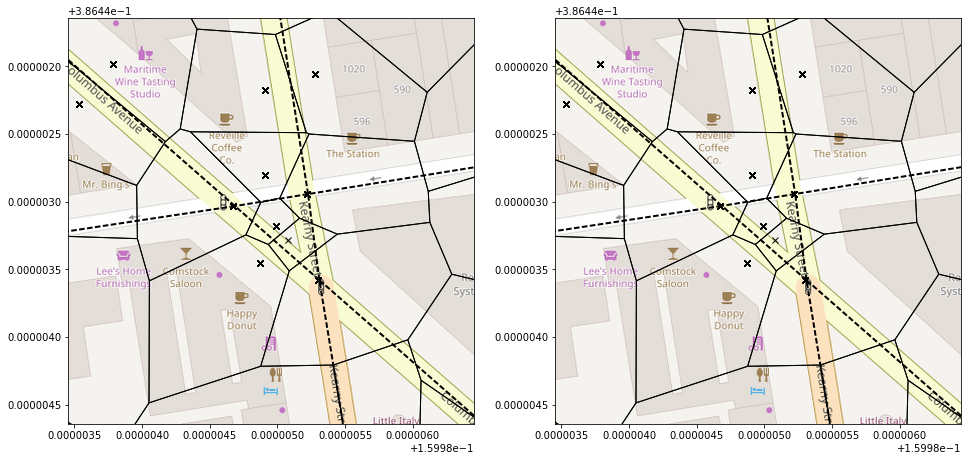

In [47]:
p = redist.polygons[areas_sort_indices[1]]
x, y = list(p.centroid.coords)[0]
ex = tilemapbase.Extent.from_centre(*project(x, y), xsize=0.000003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax in axes:
    plotter.plot(ax, alpha=0.7)

    for p in redist.polygons:
        p = shapely.ops.transform(project, p)
        p = descartes.PolygonPatch(p, fc="none", ec="black", linewidth=1)
        ax.add_patch(p)
    
    ax.scatter(*pts_wm.T, linewidth=1, color="black", marker="x")

l = matplotlib.collections.LineCollection(gr_lines, linewidth=2, color="black", linestyle="--")
axes[0].add_collection(l)

l = matplotlib.collections.LineCollection(tl_lines, linewidth=2, color="black", linestyle="--")
axes[1].add_collection(l)